# Estimating minimum sequencing depth for taxonomic profiling of metagenomic samples
We ran Kaiju, MetaPhlAn2, and Centrifuge on synthetic metagenome samples. The samples represent approximations of the expected bacterial compositions of four different sample types commonly encountered at the Centre for Translational Microbiome Research (CTMR): (intestinal) biopsies, vaginal, feces, and saliva. This Jupyter notebook was used to analyze and compare the estimated taxonomic compositions produced by the different methods.

    Fredrik Boulund, Luisa Hugerth
    2017-12-20

In [193]:
from glob import glob
from os import path
import os

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("white")

from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

from skbio.diversity import beta_diversity

In [194]:
# Create output dir for plots
try:
    os.mkdir("taxonomy_plots")
    print("Created output dir 'taxonomy_plots'.")
except OSError:
    print("Not creating output dir 'taxonomy_plots' because it already exists.")

Not creating output dir 'taxonomy_plots' because it already exists.


In [195]:
def plot_pca(df, name, taxlevel="species"):
    """
    Plot generic PCA.
    """
    # Compute PCA
    pca = PCA(n_components=2, whiten=True)
    X_reduced = pca.fit_transform(df.transpose().fillna(0))
    explained_ratio = pca.explained_variance_ratio_[0]*100+pca.explained_variance_ratio_[1]*100

    # Prepare colormap
    cmap = plt.get_cmap("tab10")
    sample_types = df.columns.get_level_values("Sample_type")
    sample_type_color = {s_type: c for c, s_type in enumerate(set(sample_types))}
    sample_colors = cmap([sample_type_color[st] for st in sample_types])

    # Plot PCA
    fig, ax = plt.subplots(figsize=(8,7))
    ax.scatter(X_reduced[:,0], X_reduced[:,1], c=sample_colors)

    # Attach a legend with square patches
    patches = [mpatches.Patch(color=cmap(c), label=sample_type) for sample_type, c in sample_type_color.items()]
    ax.legend(handles=patches)

    ax.set_title("PCA of {} composition ({})\n{:3.2f}% explained variance".format(taxlevel, name, explained_ratio))
    ax.set_xlabel("PC1\n{:2.2f}%".format(pca.explained_variance_ratio_[0]*100))
    _ = ax.set_ylabel("PC2\n{:2.2f}%".format(pca.explained_variance_ratio_[1]*100))
    return (fig, ax), (pca, X_reduced)

def plot_correlations(df, name):
    """
    Plot Pearson and Spearman correlations.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10))
    pearson = df.corr(method="pearson")
    spearman = df.corr(method="spearman")
    sns.heatmap(pearson, ax=ax1)
    sns.heatmap(spearman, ax=ax2)
    fig.suptitle("{} species composition correlations".format(name))
    ax1.set_title("Pearson")
    ax2.set_title("Spearman")
    return fig, (ax1, ax2)

# Kaiju

In [196]:
def parse_kaiju_unassigned(kaiju_summary):
    """
    Parse number/proportion of unassigned reads from Kaiju summary file.
    """
    with open(kaiju_summary) as f:
        lines = f.readlines()
        viruses = float(lines[-4].split()[0])
        unclassified = float(lines[-1].split()[0])
        return path.basename(kaiju_summary).split(".")[0], unclassified        

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


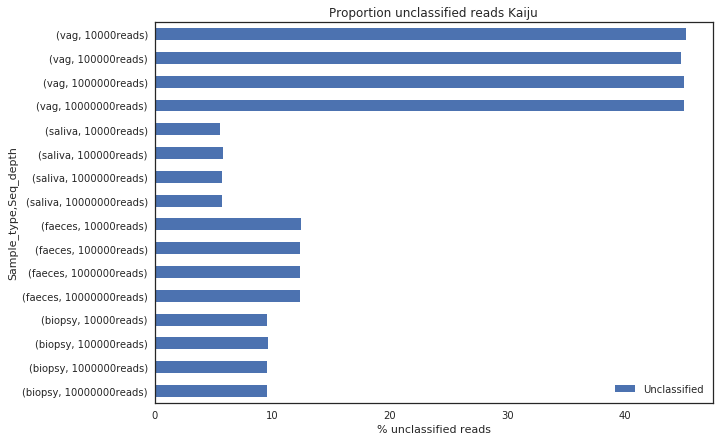

In [250]:
species_summaries = glob("/home/ctmr/projects/labcore/seq_depth/nextflow_output/kaiju/*00reads*species")
unclassified = pd.DataFrame.from_records([parse_kaiju_unassigned(fn) for fn in species_summaries], columns=["Sample", "Unclassified"])

# Create a hierachical multiindex
idx = unclassified["Sample"].str.split("_", expand=True)[[0, 1, 2]]
idx.columns = ["Sample_type", "Seq_depth", "Replicate"]
unclassified = pd.concat([unclassified["Unclassified"], idx], axis=1)
unclassified.set_index(["Sample_type", "Seq_depth", "Replicate"], inplace=True)

# Compute and plot averages per sample type and seq depth combination
fig, ax = plt.subplots(figsize=(10,7))
unclassified.groupby(["Sample_type", "Seq_depth"]).mean().plot(kind='barh', ax=ax)  
ax.set_title("Proportion unclassified reads Kaiju")
ax.set_xlabel("% unclassified reads")
fig.savefig("taxonomy_plots/"+"Kaiju_unclassified_reads.png")
fig.savefig("taxonomy_plots/"+"Kaiju_unclassified_reads.pdf")

In [255]:
# Run Python script that merges Kaiju summaries into a CSV file
!/home/ctmr/projects/labcore/seq_depth/code/estimate_seq_depth/bin/create_taxonomy_count_dataframe_kaiju.py \
    /home/ctmr/projects/labcore/seq_depth/nextflow_output/kaiju/**00reads*species \
    -p \
    -o /home/ctmr/projects/labcore/seq_depth/nextflow_output/kaiju/kaiju_dataframe.species_proportions.csv

In [200]:
kaiju = pd.read_csv("/home/ctmr/projects/labcore/seq_depth/nextflow_output/kaiju/kaiju_dataframe.species_proportions.csv")

# Set row- and column-wise indices
kaiju.set_index(["superkingdom", "phylum", "class", "order", "family", "genus", "species"], inplace=True)
kaiju.columns = kaiju.columns.str.split("_", expand=True).rename(["Sample_type", "Seq_depth", "Replicate"])
kaiju.head()

Sample_type                                                                                                                                                vag  \
Seq_depth                                                                                                                                        10000000reads   
Replicate                                                                                                                                                 1rep   
superkingdom phylum                    class        order        family           genus                   species                                                
Archaea      Candidatus Diapherotrites NaN          NaN          NaN              Candidatus Iainarchaeum Candidatus Iainarchaeum andersonii           0.00116   
             Candidatus Korarchaeota   NaN          NaN          NaN              Candidatus Korarchaeum  Candidatus Korarchaeum cryptofilum           0.00179   
             Crenarchaeota             NaN          NaN          NaN              NaN                     Crenarchaeota archaeon SCGC AAA471-B05       0.00123   
                                       Thermoprotei Acidilobales Acidilobaceae    Acidilobus              Acidilobus saccharovorans                    0.00284   
                                                                 Caldisphaeraceae Caldisphaera            Caldisphaera lagunensis                      0.00126   

Sample_type                                                                                                                                                \
Seq_depth                                                                                                                                                   
Replicate                                                                                                                                            2rep   
superkingdom phylum                    class        order        family           genus                   species                                           
Archaea      Candidatus Diapherotrites NaN          NaN          NaN              Candidatus Iainarchaeum Candidatus Iainarchaeum andersonii      0.00105   
             Candidatus Korarchaeota   NaN          NaN          NaN              Candidatus Korarchaeum  Candidatus Korarchaeum cryptofilum      0.00161   
             Crenarchaeota             NaN          NaN          NaN              NaN                     Crenarchaeota archaeon SCGC AAA471-B05  0.00109   
                                       Thermoprotei Acidilobales Acidilobaceae    Acidilobus              Acidilobus saccharovorans               0.00308   
                                                                 Caldisphaeraceae Caldisphaera            Caldisphaera lagunensis                 0.00132   

Sample_type                                                                                                                                                \
Seq_depth                                                                                                                                                   
Replicate                                                                                                                                            3rep   
superkingdom phylum                    class        order        family           genus                   species                                           
Archaea      Candidatus Diapherotrites NaN          NaN          NaN              Candidatus Iainarchaeum Candidatus Iainarchaeum andersonii      0.00113   
             Candidatus Korarchaeota   NaN          NaN          NaN              Candidatus Korarchaeum  Candidatus Korarchaeum cryptofilum      0.00189   
             Crenarchaeota             NaN          NaN          NaN              NaN                     Crenarchaeota archaeon SCGC AAA471-B05  0.00122   
                            

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


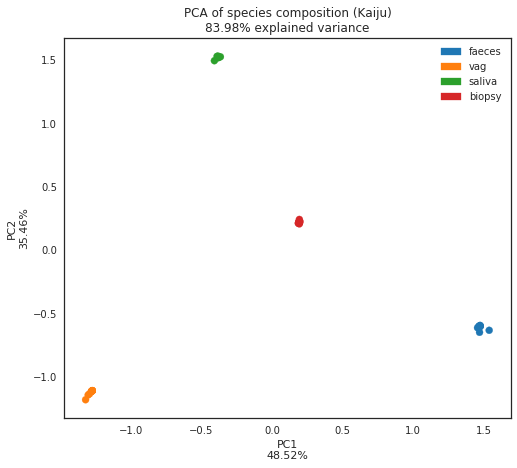

In [201]:
(fig, ax), (pca, X_reduced) = plot_pca(kaiju, "Kaiju")
fig.savefig("taxonomy_plots/"+"Kaiju_PCA_species.pdf")
fig.savefig("taxonomy_plots/"+"Kaiju_PCA_species.png")

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


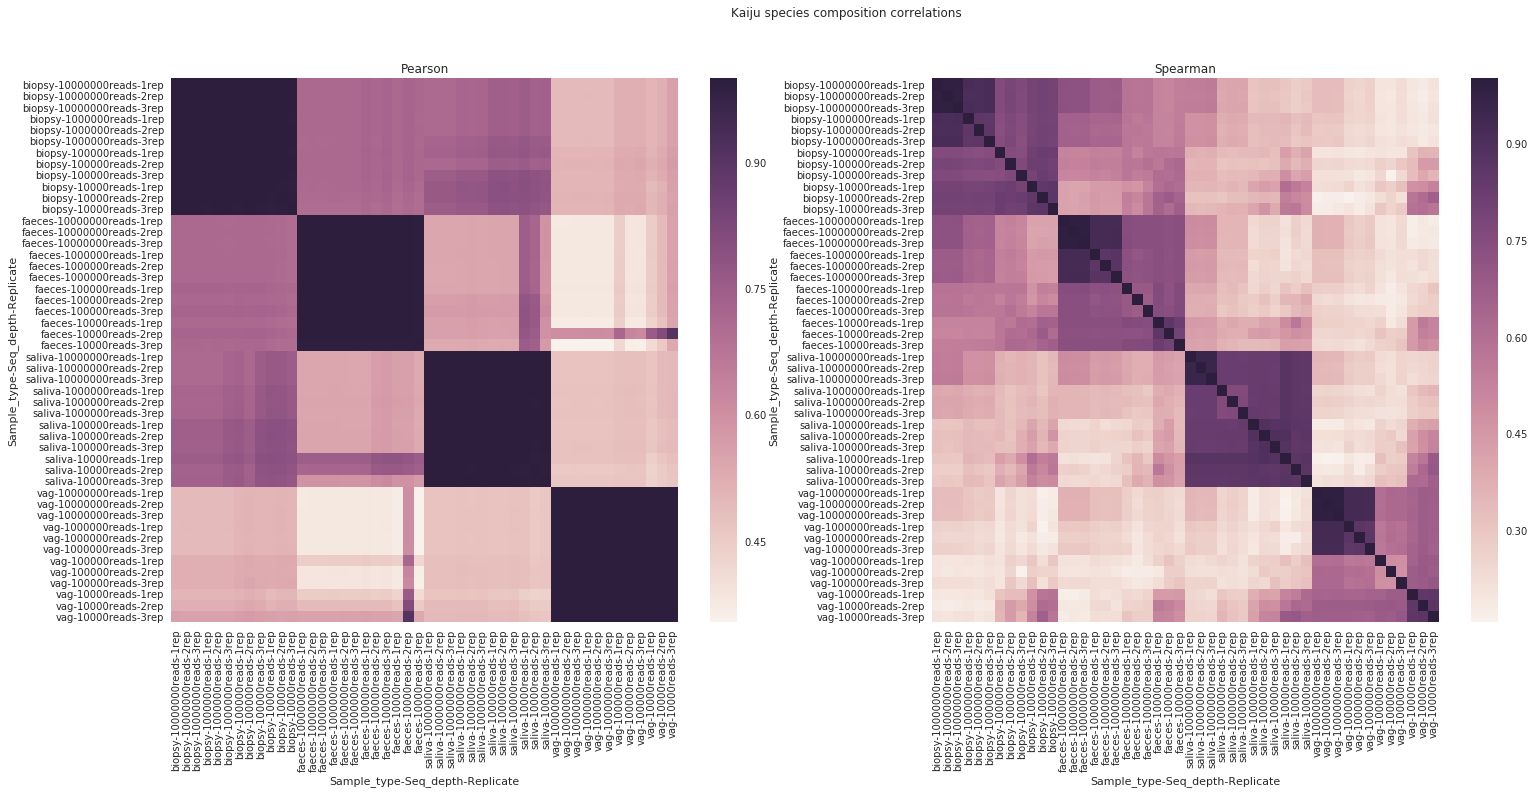

In [202]:
fig, (ax1, ax2) = plot_correlations(kaiju.sort_index(axis=1), name="Kaiju")
fig.savefig("taxonomy_plots/"+"Kaiju_correlations_species.pdf")
fig.savefig("taxonomy_plots/"+"Kaiju_correlations_species.png")

# Centrifuge

In [244]:
def parse_centrifuge_reports(filenames, proportions=True):
    """
    Parse centrifuge reports.
    """
    if isinstance(filenames, str):
        filenames = [filenames]
    dfs = []
    for filename in filenames:
        sample = path.basename(filename).split(".")[0]
        df = pd.read_csv(filename, sep="\t")
        df.set_index(["name", "taxID", "taxRank", "genomeSize"], inplace=True)
        if proportions:
            df.rename(columns={"abundance": sample}, inplace=True)
        else:
            df.rename(columns={"numReads": sample}, inplace=True)
        dfs.append(df[sample])
    return dfs

def parse_centrifuge_unclassified(filenames):
    """
    Parse proportion of unclassified reads from centrifuge output.
    """
    if isinstance(filenames, str):
        filenames = [filenames]
    stats = [] 
    for filename in filenames:
        sample = path.basename(filename).split(".")[0]
        read_classifications = pd.read_csv(filename, sep="\t")["seqID"]
        prop_unclassified = sum(read_classifications == "unclassified") / len(read_classifications)
        stats.append((sample, prop_unclassified*100))
    return pd.DataFrame.from_records(stats, columns=["Sample", "Unclassified"])

In [245]:
# Parse proportion unclassified reads from Centrifuge outputs
# WARNING: This takes a minute or two despite running in parallel; the files are large!

centrifuge_classifications = glob("/home/ctmr/projects/labcore/seq_depth/nextflow_output/centrifuge/*00reads*.centrifuge.tab")

from multiprocessing import Pool
p = Pool(10)
dfs = p.map(parse_centrifuge_unclassified, centrifuge_classifications)

In [246]:
# Make a nicer index
centrifuge_unclassified = pd.concat(dfs)
centrifuge_unclassified = pd.concat([centrifuge_unclassified["Sample"].str.split("_", expand=True), centrifuge_unclassified], axis=1)
centrifuge_unclassified = centrifuge_unclassified.rename(columns={0: "Sample_type", 1: "Seq_depth", 2: "Replicate"})

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


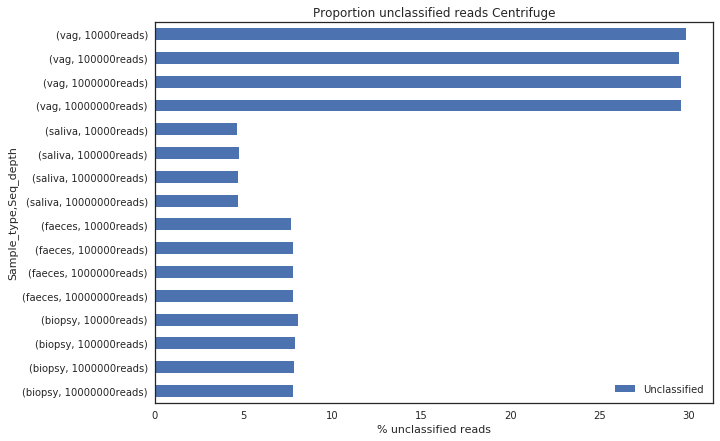

In [248]:
fig, ax = plt.subplots(figsize=(10,7))
centrifuge_unclassified.groupby(["Sample_type", "Seq_depth"]).mean().plot(kind='barh', ax=ax)
ax.set_title("Proportion unclassified reads Centrifuge")
ax.set_xlabel("% unclassified reads")
fig.savefig("taxonomy_plots/"+"Centrifuge_unclassified_reads.png")
fig.savefig("taxonomy_plots/"+"Centrifuge_unclassified_reads.pdf")

In [236]:
# Strange glob pattern due to other files we don't want to include in the same folder
centrifuge_reports = glob("/home/ctmr/projects/labcore/seq_depth/nextflow_output/centrifuge/*00reads*.centrifuge_report.tsv") 
centrifuge = pd.concat(parse_centrifuge_reports(centrifuge_reports), axis=1)
# Create hierarchical multiindex on columns
centrifuge.columns = centrifuge.columns.str.split("_", expand=True).rename(["Sample_type", "Seq_depth", "Replicate"])
centrifuge.head()

Sample_type                                                                  biopsy  \
Seq_depth                                                               100000reads   
Replicate                                                                      3rep   
name                                         taxID   taxRank genomeSize               
'Deinococcus soli' Cha et al. 2014           1309411 species 3236984            0.0   
'Nostoc azollae' 0708                        551115  leaf    5486145            NaN   
1916956                                      1916956 no rank 2750634            NaN   
1921421                                      1921421 no rank 3486308            0.0   
Abalone shriveling syndrome-associated virus 491893  species 34952              NaN   

Sample_type                                                                       vag  \
Seq_depth                                                               10000000reads   
Replicate                                                                        3rep   
name                                         taxID   taxRank genomeSize                 
'Deinococcus soli' Cha et al. 2014           1309411 species 3236984              0.0   
'Nostoc azollae' 0708                        551115  leaf    5486145              0.0   
1916956                                      1916956 no rank 2750634              0.0   
1921421                                      1921421 no rank 3486308              0.0   
Abalone shriveling syndrome-associated virus 491893  species 34952                0.0   

Sample_type                                                                   biopsy  \
Seq_depth                                                               1000000reads   
Replicate                                                                       1rep   
name                                         taxID   taxRank genomeSize                
'Deinococcus soli' Cha et al. 2014           1309411 species 3236984             0.0   
'Nostoc azollae' 0708                        551115  leaf    5486145             0.0   
1916956                                      1916956 no rank 2750634             0.0   
1921421                                      1921421 no rank 3486308             0.0   
Abalone shriveling syndrome-associated virus 491893  species 34952               NaN   

Sample_type                                                                          \
Seq_depth                                                               100000reads   
Replicate                                                                      2rep   
name                                         taxID   taxRank genomeSize               
'Deinococcus soli' Cha et al. 2014           1309411 species 3236984            NaN   
'Nostoc azollae' 0708                        551115  leaf    5486145            NaN   
1916956                                      1916956 no rank 2750634            NaN   
1921421                                      1921421 no rank 3486308            0.0   
Abalone shriveling syndrome-associated virus 491893  species 34952              NaN   

Sample_type                                                                           \
Seq_depth                                                               1000000reads   
Replicate                                                                       2rep   
name                                         taxID   taxRank genomeSize                
'Deinococcus soli' Cha et al. 2014           1309411 species 3236984             0.0   
'Nostoc azollae' 0708                        551115  leaf    5486145             0.0   
1916956                                      1916956 no rank 2750634             0.0   
1921421                                      1921421 no rank 3486308             0.0   
Abalone shriveling syndrome-associated virus 491893  species 34952               NaN   

Sample_type                                 

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


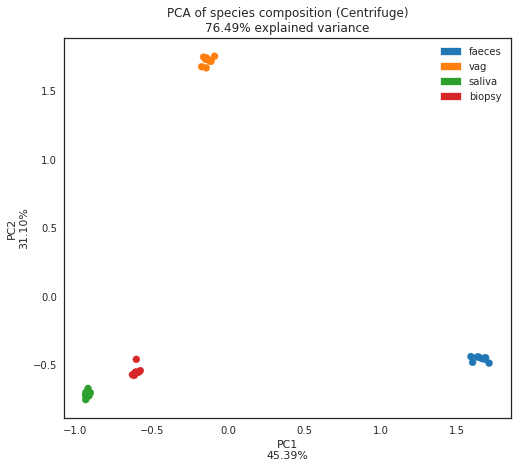

In [237]:
centrifuge_species = centrifuge.xs(level="taxRank", key="species")
(fig, ax), (pca, X_reduced) = plot_pca(centrifuge_species, "Centrifuge")
fig.savefig("taxonomy_plots/"+"Centrifuge_PCA_species.pdf")
fig.savefig("taxonomy_plots/"+"Centrifuge_PCA_species.png")

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


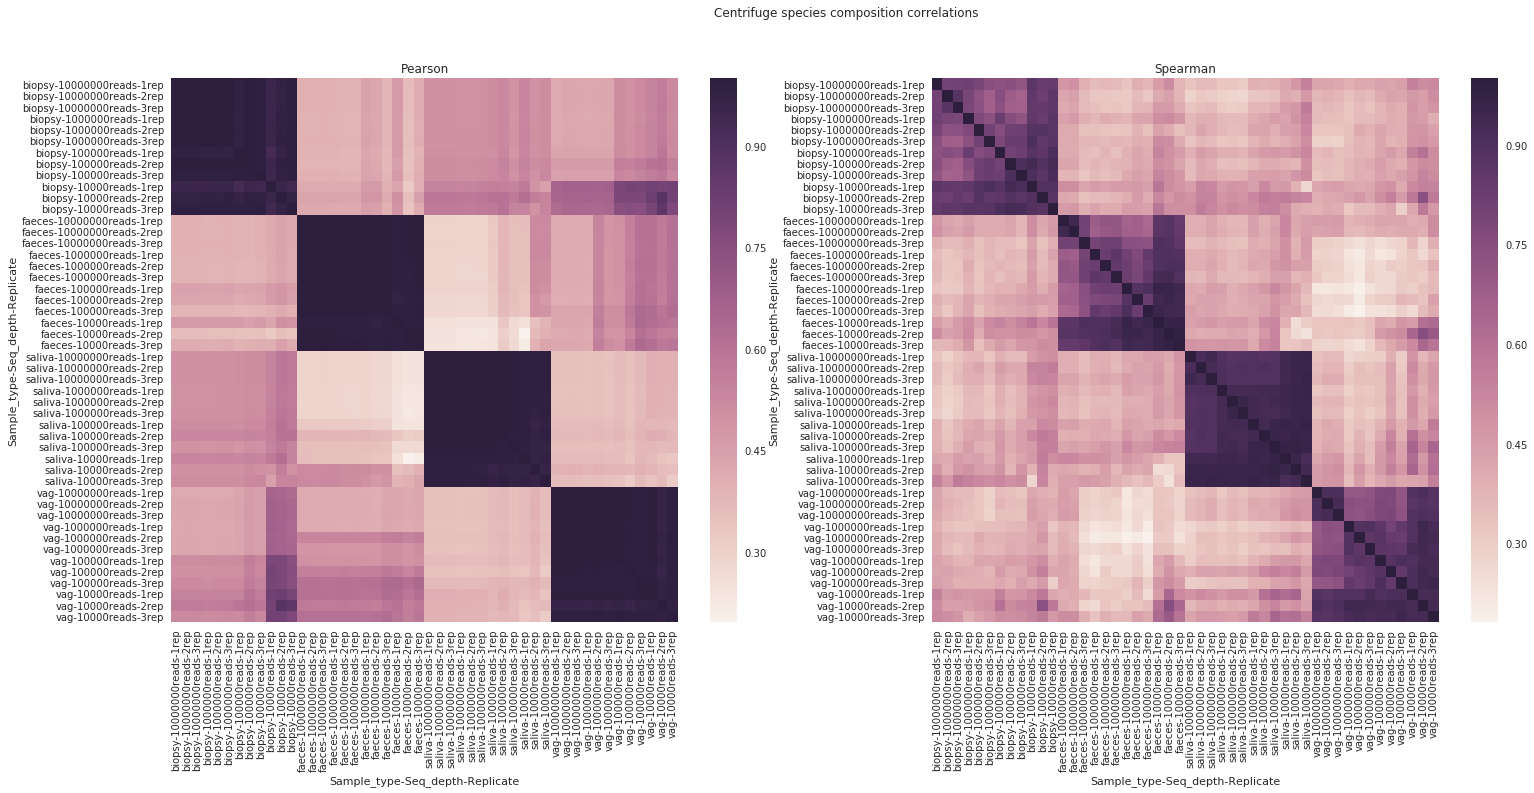

In [238]:
fig, (ax1, ax2) = plot_correlations(centrifuge_species.sort_index(axis=1), name="Centrifuge")
fig.savefig("taxonomy_plots/"+"Centrifuge_correlations_species.pdf")
fig.savefig("taxonomy_plots/"+"Centrifuge_correlations_species.png")

# MetaPhlAn2

In [263]:
# Run metaphlan2 script to merge metaphlan2 outputs
!source activate metaphlan2 ; \
    merge_metaphlan_tables.py \
        /home/ctmr/projects/labcore/seq_depth/nextflow_output/metaphlan2/*00reads*metaphlan2.txt \
        > /home/ctmr/projects/labcore/seq_depth/nextflow_output/metaphlan2/merged_metaphlan.txt

In [264]:
metaphlan2 = pd.read_csv("/home/ctmr/projects/labcore/seq_depth/nextflow_output/metaphlan2/merged_metaphlan.txt", sep="\t", skiprows=1)

In [265]:
metaphlan2.set_index("#SampleID", inplace=True)  # Set index to easily create hiearchical multiindex over sample columns 
metaphlan2.columns = metaphlan2.columns.str.split("_", expand=True).rename(["Sample_type", "Seq_depth", "Replicate"])

In [266]:
metaphlan2.reset_index(inplace=True)  # Need to reset index again to get easy access to index column

# Select rows with species information (and not strain)
contains_species = metaphlan2["#SampleID"].str.contains(r's__.*$')
contains_strain = metaphlan2["#SampleID"].str.contains(r't__.*$')
species_only = contains_species & ~contains_strain
metaphlan2_species = metaphlan2[species_only]

# Extract taxonomic lineage
levels=["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"]
mpa_lineage = metaphlan2_species["#SampleID"].str.split("|", expand=True).rename(columns={k: v for k, v in enumerate(levels)})

# Clean up names (remove ugly leading prefixes)
for level in levels:
    mpa_lineage[level] = mpa_lineage[level].str.split("__", expand=True).iloc[:,1]
    
# Merge new hierarchical index with original dataframe
del metaphlan2_species["#SampleID"]
mpa_species = mpa_lineage.join(metaphlan2_species).set_index(levels)  # Join on shared indices and create new index on taxonomy hierarchy
mpa_species.columns = pd.MultiIndex.from_tuples(mpa_species.columns, names=["Sample_type", "Seq_depth", "Replicate"])  # Restore broken column multiindex
mpa_species.head()

/home/ctmr/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


Sample_type                                                                                                                                     biopsy  \
Seq_depth                                                                                                                                10000000reads   
Replicate                                                                                                                                         1rep   
Kingdom  Phylum         Class          Order                 Family                Genus                 Species                                         
Bacteria Actinobacteria Actinobacteria Actinobacteria_noname Actinobacteria_noname Actinobacteria_noname actinobacterium_SCGC_AAA278_O22       0.01143   
                                       Actinomycetales       Actinomycetaceae      Actinomyces           Actinomyces_oris                      0.00000   
                                                                                                         Actinomyces_timonensis                0.00000   
                                                                                                         Actinomyces_viscosus                  0.00000   
                                                                                   Mobiluncus            Mobiluncus_curtisii                   0.85770   

Sample_type                                                                                                                                        \
Seq_depth                                                                                                                                           
Replicate                                                                                                                                    2rep   
Kingdom  Phylum         Class          Order                 Family                Genus                 Species                                    
Bacteria Actinobacteria Actinobacteria Actinobacteria_noname Actinobacteria_noname Actinobacteria_noname actinobacterium_SCGC_AAA278_O22  0.00914   
                                       Actinomycetales       Actinomycetaceae      Actinomyces           Actinomyces_oris                 0.00000   
                                                                                                         Actinomyces_timonensis           0.00000   
                                                                                                         Actinomyces_viscosus             0.00000   
                                                                                   Mobiluncus            Mobiluncus_curtisii              0.84306   

Sample_type                                                                                                                                        \
Seq_depth                                                                                                                                           
Replicate                                                                                                                                    3rep   
Kingdom  Phylum         Class          Order                 Family                Genus                 Species                                    
Bacteria Actinobacteria Actinobacteria Actinobacteria_noname Actinobacteria_noname Actinobacteria_noname actinobacterium_SCGC_AAA278_O22  0.01184   
                                       Actinomycetales       Actinomycetaceae      Actinomyces           Actinomyces_oris                 0.00000   
                                                                                                         Actinomyces_timonensis           0.00000   
                                                                                                         Actinomyces_viscosus             0.00000   
                                                                               

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


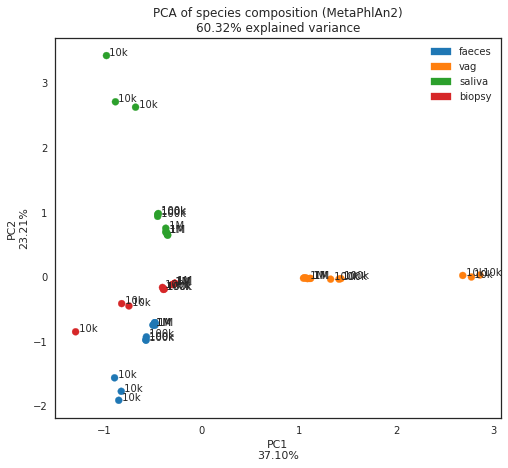

In [277]:
(fig, ax), (pca, X_reduced) = plot_pca(mpa_species, "MetaPhlAn2")
fig.savefig("taxonomy_plots/"+"MetaPhlAn2_PCA_species.pdf")
fig.savefig("taxonomy_plots/"+"MetaPhlAn2_PCA_species.png")

for sample, point in zip(mpa_species.columns, X_reduced):
    text = ""
    if sample[1] == "10000reads":
        text = " 10k"
    elif sample[1] == "100000reads":
        text = " 100k"
    elif sample[1] == "1000000reads":
        text = " 1M"
    ax.annotate(text, point)

/home/ctmr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


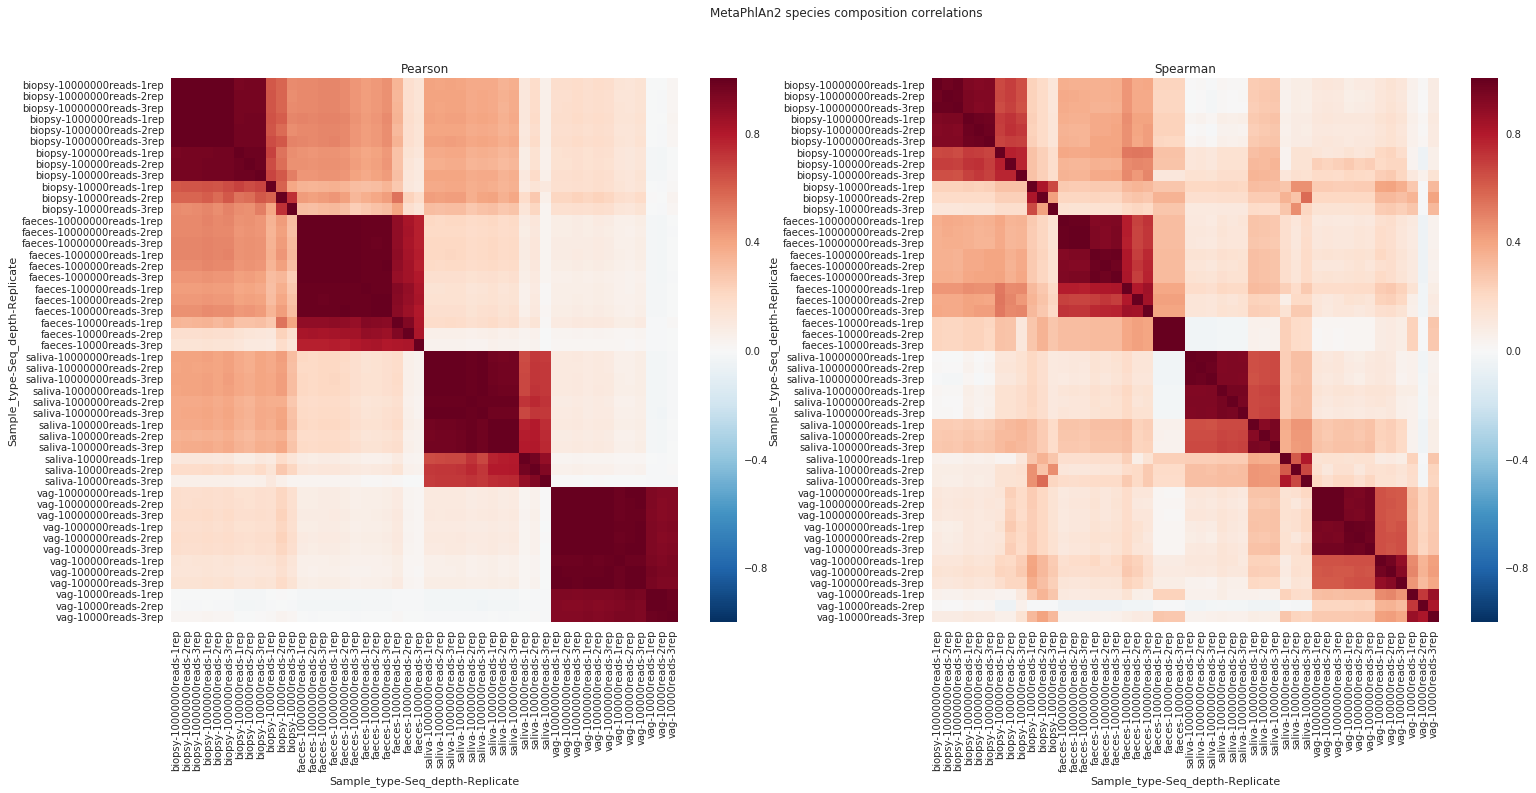

In [268]:
fig, (ax1, ax2) = plot_correlations(mpa_species.fillna(0).sort_index(axis=1), name="MetaPhlAn2")
fig.savefig("taxonomy_plots/"+"MetaPhlAn2_correlations_species.pdf")
fig.savefig("taxonomy_plots/"+"MetaPhlAn2_correlations_species.png")